# Introduction

The main goals of the project are:

1. To find important features of medical practitioners who prescribe opioids. This will be a challenge due to the number of drugs and medical specialties included in the prescribing data.
2. Develop a classifier to predict if a given medical practitioner frequently prescribes opioids (defined as more than 10 times a year).

Below are links to further gain insights and contexts of the opioids crisis in the US before performing any analysis. 
The main dataset was obtained from [this Kaggle link](https://www.kaggle.com/datasets/apryor6/us-opiate-prescriptions).

* [IQVIA article on prescription opioids trends in the US](https://www.iqvia.com/insights/the-iqvia-institute/reports/prescription-opioid-trends-in-the-united-states)

* [IQVIA article on the context about opioids crisis](https://www.iqvia.com/blogs/2019/07/the-opioid-crisis-the-data-the-science-and-the-humanity)

* [CDC general study on opioids use in the US](https://www.cdc.gov/mmwr/preview/mmwrhtml/mm6450a3.htm)

* [CDC dashboard on fatal overdose stats](https://www.cdc.gov/drugoverdose/fatal/dashboard/index.html)



After having somewhat understood the context and need for a solution to this problem, we will now perform exploratory data analysis on the 2014 Kaggle dataset.

# Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import plotly.express as px
import os
import re
from bs4 import BeautifulSoup
import requests
from plotly.offline import plot

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# pd.set_option("display.max_rows", None)
#df = df.loc[:, df.any()]
#df['Specialty'].value_counts()

There are 3 datasets available

1. opioids.csv - data on a list of drug names and its generic name
2. prescribers-info.csv - data on prescribers having the count of each drug which they prescribed
3. overdoses.csv - data about state population and deaths due to opioids

In [3]:
df = pd.read_csv('prescriber-info.csv')
opioids = pd.read_csv('opioids.csv')

We will clean the data by including all 50 states and Washington D.C. in the data, but we will filter out other US territories like PR, VI, ZZ, AE, GU, AA. This is due to the fact that CDC data do not include these regions.

Please note that below table shows we have around 250 drugs and 6 columns of data about prescriber information (NPI, Gender, State, Credentials, Specialty, Opioid.Prescriber). Opioid.Prescriber is our response variable.

In [4]:
tables = pd.read_html(r'https://www.infoplease.com/us/postal-information/state-abbreviations-and-state-postal-codes') # get list of state abbreviations
states = tables[0]['Postal Code'] # 51 entries, including DC
df['State'] = np.where(df['State'].isin(states), df['State'], 'Other')
df = df[~df.State.str.contains('Other')] #include DC but exclude PR, VI, ZZ, AE, GU, AA # 24759 rows
df = df.loc[:, df.any()] # remove drugs which were not prescribed
df

,NPI,Gender,State,Credentials,Specialty,ABILIFY,ACETAMINOPHEN.CODEINE,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,...,VERAPAMIL.ER,VESICARE,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid.Prescriber
0,1710982582,M,TX,DDS,Dentist,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1245278100,F,AL,MD,General Surgery,0,0,0,0,0,...,0,0,0,0,0,0,0,0,35,1
2,1427182161,F,NY,M.D.,General Practice,0,0,0,0,0,...,0,0,0,0,0,0,0,0,25,0
3,1669567541,M,AZ,MD,Internal Medicine,0,43,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1679650949,M,NV,M.D.,Hematology/Oncology,0,0,0,0,0,...,0,0,0,0,17,28,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,1619019353,F,WA,M.D.,Family Practice,0,12,0,0,0,...,0,0,0,0,39,0,0,0,0,1
24996,1780693671,F,MI,DO,Internal Medicine,0,15,0,0,0,...,0,0,0,0,20,0,0,0,0,1
24997,1346270956,M,AZ,MD,Emergency Medicine,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
24998,1023116514,F,IN,M.D.,Family Practice,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


Out of the 250 drugs listed in the data, 11 of them are opioids, as shown below.

In [5]:
# replace spaces and hypens with periods

opioids["Drug Name"] = opioids["Drug Name"].replace('-', '.', regex=True)
opioids["Drug Name"] = opioids["Drug Name"].replace(' ', '.', regex=True)

#opioids names matching with the drug columns from prescriber info
set(opioids['Drug Name']) & set(df.columns.tolist())

{'ACETAMINOPHEN.CODEINE',
 'FENTANYL',
 'HYDROCODONE.ACETAMINOPHEN',
 'HYDROMORPHONE.HCL',
 'METHADONE.HCL',
 'MORPHINE.SULFATE',
 'MORPHINE.SULFATE.ER',
 'OXYCODONE.ACETAMINOPHEN',
 'OXYCODONE.HCL',
 'OXYCONTIN',
 'TRAMADOL.HCL'}

We will attempt to clean up our specialty into larger categories. If specialties listed appear less than 10 times, they will be categorized into "others" category, which will be excluded from this analysis because of very few data points being merged into "others" category from wide range of specialties.

We have listed 20 largest number of specialty groups below.

In [6]:
# clean specialty values
df.loc[df['Specialty'].str.contains('Nurse'), 'Specialty'] = 'Nurse'
df.loc[df['Specialty'].str.contains('rectal', case=False), 'Specialty'] = 'Colorectal Surgery'
df.loc[df['Specialty'].str.contains('Physical'), 'Specialty'] = 'Physical Medicine'
df.loc[df['Specialty'].str.contains('Psychologist'), 'Specialty'] = 'Psychologist'
df.loc[df['Specialty'].str.contains('Pain'), 'Specialty'] = 'Pain Management'
df.loc[df['Specialty'].str.contains('Cardiac'), 'Specialty'] = 'Cardiology'
df.loc[df['Specialty'].str.contains('Oncology'), 'Specialty'] = 'Oncology'
df.loc[df['Specialty'].str.contains('Psychiatry', case=False), 'Specialty'] = 'Psychiatry'
df.loc[df['Specialty'].str.contains('Radiology'), 'Specialty'] = 'Radiology'
df.loc[df['Specialty'].str.contains('neuro', case=False), 'Specialty'] = 'Neurology'
df.loc[df['Specialty'].str.contains('Oral'), 'Specialty'] = 'Oral Surgery'
df.loc[df['Specialty'].str.contains('Radiology'), 'Specialty'] = 'Radiology'
df.loc[df['Specialty'].str.contains('Sports'), 'Specialty'] = 'Physical Medicine'
df.loc[df['Specialty'].str.contains('ortho', case=False), 'Specialty'] = 'Orthopedic Surgery'
df.loc[df['Specialty'].str.contains('Plastic'), 'Specialty'] = 'Plastic Surgery'
df.loc[df['Specialty'].str.contains('Family'), 'Specialty'] = 'Family Medicine'
df.loc[df.groupby('Specialty').Specialty.transform('count').lt(10), 'Specialty'] = 'Other'
df = df[~df.Specialty.str.contains('Other')] # exclude Other --> 24679 rows
df.loc[df['Specialty'] == 'Student in an Organized Health Care Education/Training Program', 'Specialty'] = 'Medical Students, Interns, Residents'
df['Specialty'].value_counts()[:20]

/Users/davidjeong/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Internal Medicine                       3162
Family Medicine                         2977
Dentist                                 2771
Nurse                                   2629
Physician Assistant                     1838
Emergency Medicine                      1081
Psychiatry                              1005
Cardiology                               727
Obstetrics/Gynecology                    606
Orthopedic Surgery                       605
Optometry                                571
Medical Students, Interns, Residents     545
Ophthalmology                            514
General Surgery                          484
Neurology                                455
Oncology                                 418
Gastroenterology                         394
Podiatry                                 367
Dermatology                              343
Urology                                  328
Name: Specialty, dtype: int64

In [7]:
#summary stats (non-zero values only)
display(df.mask(df == 0).describe())

drug_summary = df.mask(df == 0).describe() # abilify count should be 1578
drug_summary = drug_summary.T[1:]
drug_summary =  drug_summary[:-1]
drug_summary = drug_summary.iloc[:,0]
drug_summary = drug_summary.reset_index()
drug_summary =  drug_summary.sort_values(by=['count'], ascending=False)

,NPI,ABILIFY,ACETAMINOPHEN.CODEINE,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,ALENDRONATE.SODIUM,ALLOPURINOL,ALPRAZOLAM,AMIODARONE.HCL,...,VERAPAMIL.ER,VESICARE,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid.Prescriber
count,2.467900e+04,1578.000000,2112.000000,1158.000000,4001.000000,782.000000,4242.000000,4502.000000,5065.000000,1641.000000,...,2055.000000,1677.000000,1595.000000,907.000000,5592.000000,2066.000000,2664.000000,693.000000,5189.000000,14507.0
mean,1.498244e+09,49.612167,27.687973,22.552677,43.734816,22.473146,51.208864,51.008219,78.416979,36.209628,...,24.601460,33.354204,39.275235,21.551268,85.274499,40.013553,37.669294,40.181818,54.260166,1.0
std,2.876965e+08,67.011960,29.503770,21.530712,50.759422,19.529056,73.038192,50.291151,136.509271,43.240915,...,16.903941,40.125903,83.464739,13.573379,166.613297,45.201929,43.640113,47.445483,62.489936,0.0
min,1.003002e+09,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,...,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,1.0
25%,1.245498e+09,15.000000,14.000000,13.000000,17.000000,12.000000,18.000000,19.000000,20.000000,15.000000,...,14.000000,14.000000,14.000000,13.000000,21.000000,15.000000,16.000000,14.000000,18.000000,1.0
50%,1.497838e+09,26.000000,19.000000,16.000000,29.000000,16.000000,32.000000,34.000000,41.000000,22.000000,...,19.000000,21.000000,21.000000,17.000000,44.000000,24.000000,25.000000,24.000000,34.000000,1.0
75%,1.740409e+09,53.000000,31.000000,24.000000,51.000000,24.000000,60.000000,66.000000,89.000000,40.000000,...,29.000000,36.000000,36.000000,25.000000,99.000000,46.000000,43.000000,49.000000,68.000000,1.0
max,1.992999e+09,770.000000,644.000000,356.000000,1105.000000,275.000000,2431.000000,790.000000,5716.000000,596.000000,...,169.000000,902.000000,1814.000000,143.000000,6029.000000,596.000000,772.000000,694.000000,1707.000000,1.0


Below is a table for 15 most prescribed drugs.

In [8]:
drug_summary.head(15)

,index,count
100,HYDROCODONE.ACETAMINOPHEN,10015.0
130,LISINOPRIL,8447.0
174,OMEPRAZOLE,8136.0
10,AMLODIPINE.BESYLATE,8011.0
89,GABAPENTIN,7729.0
16,ATORVASTATIN.CALCIUM,7586.0
88,FUROSEMIDE,7404.0
128,LEVOTHYROXINE.SODIUM,7317.0
212,SIMVASTATIN,7311.0
151,METOPROLOL.TARTRATE,6932.0


/var/folders/b9/n9n2pqbs2qzccwsqtd9j33wm0000gn/T/ipykernel_39210/3534634290.py:12: MatplotlibDeprecationWarning:

The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.

/var/folders/b9/n9n2pqbs2qzccwsqtd9j33wm0000gn/T/ipykernel_39210/3534634290.py:15: MatplotlibDeprecationWarning:

The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.



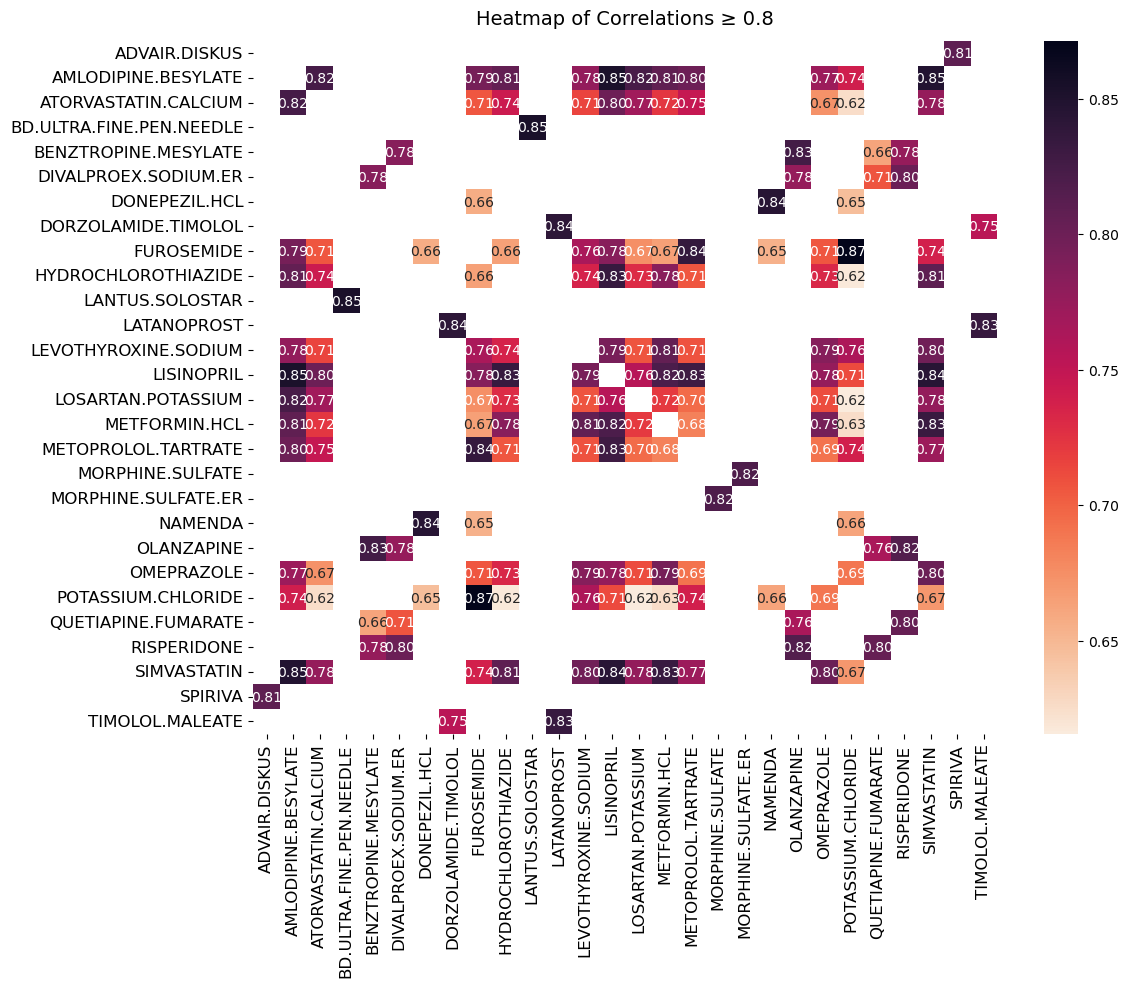

In [9]:
import seaborn as sns
df_drugs = df.iloc[:,0:239]
corr = df_drugs.corr()
np.fill_diagonal(corr.values, 0)
high_corr = [column for column in corr.columns if any(corr[column] >= 0.8)] # find columns with correlation > 0.85
# can look at corr > 0.8 if we have time

#plt.figure(figsize=(5, 4)) # for corr > 0.85 plot
#plt.figure(figsize=(18, 16)) # for corr > 0.8 plot
fig, axes = plt.subplots(figsize=(12, 9))
for tick in axes.xaxis.get_major_ticks():
    tick.label.set_fontsize(12)

for tick in axes.yaxis.get_major_ticks():
    tick.label.set_fontsize(12)

dfCorr = df_drugs[high_corr].corr()
filteredDf = dfCorr[((dfCorr >= .6) | (dfCorr <= -.6)) & (dfCorr !=1.000)]

    
heatmap = sns.heatmap(filteredDf, annot=True, fmt=".2f", cmap='rocket_r')
heatmap.set_title('Heatmap of Correlations ≥ 0.8', fontdict={'fontsize':14}, pad=12);
plt.savefig('corr.png', dpi=300, bbox_inches='tight')

In [10]:
def corrFilter(x: pd.DataFrame, bound: float):
    xCorr = x.corr()
    xFiltered = xCorr[((xCorr >= bound) | (xCorr <= -bound)) & (xCorr !=1.000)]
    xFlattened = xFiltered.unstack().sort_values().drop_duplicates()
    return xFlattened

df_corr_summary = pd.DataFrame(corrFilter(dfCorr, .8)).reset_index()
df_corr_summary.columns =['Drug1','Drug2','Correlation']
df_corr_summary = df_corr_summary.sort_values(by=['Correlation'], ascending=False)
df_corr_summary.head(20)

,Drug1,Drug2,Correlation
86,LISINOPRIL,AMLODIPINE.BESYLATE,0.990588
85,SIMVASTATIN,LISINOPRIL,0.990289
84,SIMVASTATIN,AMLODIPINE.BESYLATE,0.989226
83,FUROSEMIDE,POTASSIUM.CHLORIDE,0.989162
82,DORZOLAMIDE.TIMOLOL,LATANOPROST,0.986666
81,HYDROCHLOROTHIAZIDE,LISINOPRIL,0.985828
80,LATANOPROST,TIMOLOL.MALEATE,0.985371
79,HYDROCHLOROTHIAZIDE,SIMVASTATIN,0.985067
78,AMLODIPINE.BESYLATE,ATORVASTATIN.CALCIUM,0.984432
77,METFORMIN.HCL,SIMVASTATIN,0.983203


Instead of simply looking at states, we will also try to break down the data into regions to review the data by regions.

In [11]:
#Create df for state and count every row, grouped by state
df_state = df[['State','NPI']].groupby('State').count()
df_state.reset_index(level = 0,inplace = True)
df_state.columns = ['State','Total Drug Prescribers']
#Create df for opioids and add all 1's, grouped by specialty and join them
df_opioids = pd.DataFrame(df.groupby(['State'])['Opioid.Prescriber'].sum())
df_opioids.reset_index(level = 0,inplace = True)
df_opioids.columns = ['State','Total Opioid Prescribers']
df_state = df_state.merge(df_opioids, how = 'left', on = 'State')
#Create nonopioids prescribers column by state and sort by descending order for opioids prescribers
df_state['Total Nonopioid Prescribers'] = df_state['Total Drug Prescribers'] - df_state['Total Opioid Prescribers']
df_state['Percentage of Opioids Prescribers'] = df_state['Total Opioid Prescribers']/df_state['Total Drug Prescribers']
df_state =  df_state.sort_values(by=['Total Opioid Prescribers'], ascending=False)
df_state.head(10)


,State,Total Drug Prescribers,Total Opioid Prescribers,Total Nonopioid Prescribers,Percentage of Opioids Prescribers
4,CA,2551,1457,1094,0.571149
43,TX,1499,949,550,0.633089
34,NY,1948,874,1074,0.448665
9,FL,1562,869,693,0.556338
38,PA,1206,679,527,0.563018
35,OH,980,563,417,0.574490
14,IL,1001,555,446,0.554446
22,MI,871,553,318,0.634902
27,NC,777,498,279,0.640927
10,GA,609,397,212,0.651888


In [12]:
df_state =  df_state.sort_values(by=['Percentage of Opioids Prescribers'], ascending=False)
df_state.head(10)

,State,Total Drug Prescribers,Total Opioid Prescribers,Total Nonopioid Prescribers,Percentage of Opioids Prescribers
2,AR,214,158,56,0.738318
36,OK,281,205,76,0.729537
26,MT,77,55,22,0.714286
1,AL,344,244,100,0.709302
33,NV,155,108,47,0.696774
0,AK,39,27,12,0.692308
25,MS,193,130,63,0.673575
13,ID,132,88,44,0.666667
40,SC,388,257,131,0.662371
44,UT,161,106,55,0.658385


California, Texas, New York, Florida, Pennsylvania, and Ohio are among the highest in terms of number of opioids prescribers in the state. We will keep that in mind as we analyze the data further. Arkansas, Oklahoma, Montana, Alabama, Nevada, Alaska, Missouri, Idaho are among the highest in terms of the highest percentage of opioids prescribers in the prescriber info dataset. Also, keep in mind that highest percentage might be influenced by how few the sample sizes are for particular states.

Total number of Drug prescribers, total number of opioids prescribers, total number of nonopioids prescribers by specialty and region. Family medicine and internal medicine stand out for specialty. Region is somewhat of a mix.

In [16]:
#create DF for regional analysis instead of state analysis 
table = pd.read_html(r'https://www.infoplease.com/us/states/regions-of-the-us') # get list of regions and states

#rename columns
table[0].columns = ['Region','States']

#get region into list
region_list = table[0]['Region'].tolist()

#Make state list from pd.Series
state_list = [ i.split(", ") for i in table[0]['States'].tolist()]
#add DC to list
state_list[1].append('District of Columbia')
#Create dictionary region as key and states (lists) as values
region_dict = {region: states for region, states in zip(region_list, state_list)}
#explode regions for every state
region_df = pd.Series(region_dict, name='States').rename_axis('Region').explode().reset_index()


tables = pd.read_html(r'https://www.infoplease.com/us/postal-information/state-abbreviations-and-state-postal-codes') # get list of state abbreviations
states_tables = tables[0][['State Name/District','Postal Code']] # 51 entries, including DC
#merge table
region_df = region_df.merge(states_tables, how = 'left', left_on = 'States', right_on = 'State Name/District' )
del region_df['State Name/District']

region_df.head(15)

,Region,States,Postal Code
0,New England,Connecticut,CT
1,New England,Maine,ME
2,New England,Massachusetts,MA
3,New England,New Hampshire,NH
4,New England,Rhode Island,RI
5,New England,Vermont,VT
6,Middle Atlantic,Delaware,DE
7,Middle Atlantic,Maryland,MD
8,Middle Atlantic,New Jersey,NJ
9,Middle Atlantic,New York,NY


In [17]:
df_specialty_region = df[['Specialty','State','NPI']].groupby(['Specialty','State']).count()
df_specialty_region = df_specialty_region.reset_index()
df_specialty_region.columns = ['Specialty','State','Total Drug Prescribers']
#join by region and sum
df_specialty_region = df_specialty_region.merge(region_df, how = 'left', left_on = 'State', right_on = 'Postal Code')


df_specialty_region = df_specialty_region.drop(['State','Postal Code','States'], axis=1)

df_specialty_region = df_specialty_region[['Specialty', 'Region', 'Total Drug Prescribers']]

df_specialty_region = pd.DataFrame(df_specialty_region.groupby(['Specialty','Region'])['Total Drug Prescribers'].sum())


df_specialty_region = df_specialty_region.reset_index()


In [18]:
df_opi_region = pd.DataFrame(df.groupby(['Specialty','State'])['Opioid.Prescriber'].sum())
df_opi_region = df_opi_region.reset_index() #level = 0,inplace = True

df_opi_region = df_opi_region.merge(region_df, how = 'left', left_on = 'State', right_on = 'Postal Code')

df_opi_region = df_opi_region.drop(['State','Postal Code','States'], axis=1)

df_opi_region.columns = ['Specialty', 'Total Opioid Prescribers', 'Region']
df_opi_region = df_opi_region[['Specialty','Region' , 'Total Opioid Prescribers']]

df_opi_region = pd.DataFrame(df_opi_region.groupby(['Specialty','Region'])['Total Opioid Prescribers'].sum())

df_opi_region = df_opi_region.reset_index()

df_specialty_region = df_specialty_region.merge(df_opi_region, how ='left', on =['Specialty','Region'])
df_specialty_region =  df_specialty_region.sort_values(by=['Total Opioid Prescribers'], ascending=False)
df_specialty_region['Total Nonopioid Prescribers'] = df_specialty_region['Total Drug Prescribers'] - df_specialty_region['Total Opioid Prescribers']



In [19]:
display(df_specialty_region.head(15))

,Specialty,Region,Total Drug Prescribers,Total Opioid Prescribers,Total Nonopioid Prescribers
56,Family Medicine,South,801,717,84
54,Family Medicine,Midwest,738,659,79
112,Internal Medicine,South,800,628,172
58,Family Medicine,West,608,538,70
109,Internal Medicine,Middle Atlantic,681,495,186
114,Internal Medicine,West,573,448,125
110,Internal Medicine,Midwest,552,423,129
145,Nurse,South,800,393,407
32,Dentist,South,703,383,320
53,Family Medicine,Middle Atlantic,396,331,65


In [20]:
df_specialty = df[['Specialty','NPI']].groupby('Specialty').count()
df_specialty.reset_index(level = 0,inplace = True)
df_specialty.columns = ['Specialty','Total Drug Prescribers']

In [21]:
#df.loc[df['Opioid.Prescriber']> 0,['Specialty','NPI']].groupby('Specialty').count()
df_opioids = pd.DataFrame(df.groupby(['Specialty'])['Opioid.Prescriber'].sum())
df_opioids.reset_index(level = 0,inplace = True)
df_opioids.columns = ['Specialty','Total Opioid Prescribers']
df_specialty = df_specialty.merge(df_opioids, how = 'left', on = 'Specialty')


In [22]:
df_specialty['Total Nonopioid Prescribers'] = df_specialty['Total Drug Prescribers'] - df_specialty['Total Opioid Prescribers']
df_specialty =  df_specialty.sort_values(by=['Total Opioid Prescribers'], ascending=False)
df_specialty.loc[48, 'Specialty'] = 'Medical Students, Interns, Residents'
#df_specialty.at['Student in an Organized Health Care Education/Training Program', 'Specialty'] = 'Medical Students, Interns, Residents'

In [23]:
df_specialty.head(10)

,Specialty,Total Drug Prescribers,Total Opioid Prescribers,Total Nonopioid Prescribers
9,Family Medicine,2977,2633,344
19,Internal Medicine,3162,2399,763
25,Nurse,2629,1371,1258
39,Physician Assistant,1838,1261,577
5,Dentist,2771,1056,1715
7,Emergency Medicine,1081,1040,41
31,Orthopedic Surgery,605,589,16
12,General Surgery,484,439,45
27,Oncology,418,369,49
24,Neurology,455,270,185


In [24]:
df_specialty_percentage = df_specialty.copy()
df_specialty_percentage['Percentage of Opioids Prescribers'] = df_specialty_percentage['Total Opioid Prescribers']/df_specialty_percentage['Total Drug Prescribers']
df_specialty_percentage =  df_specialty_percentage.sort_values(by=['Percentage of Opioids Prescribers'], ascending=False)
#df_specialty_percentage = df_specialty_percentage[1:]



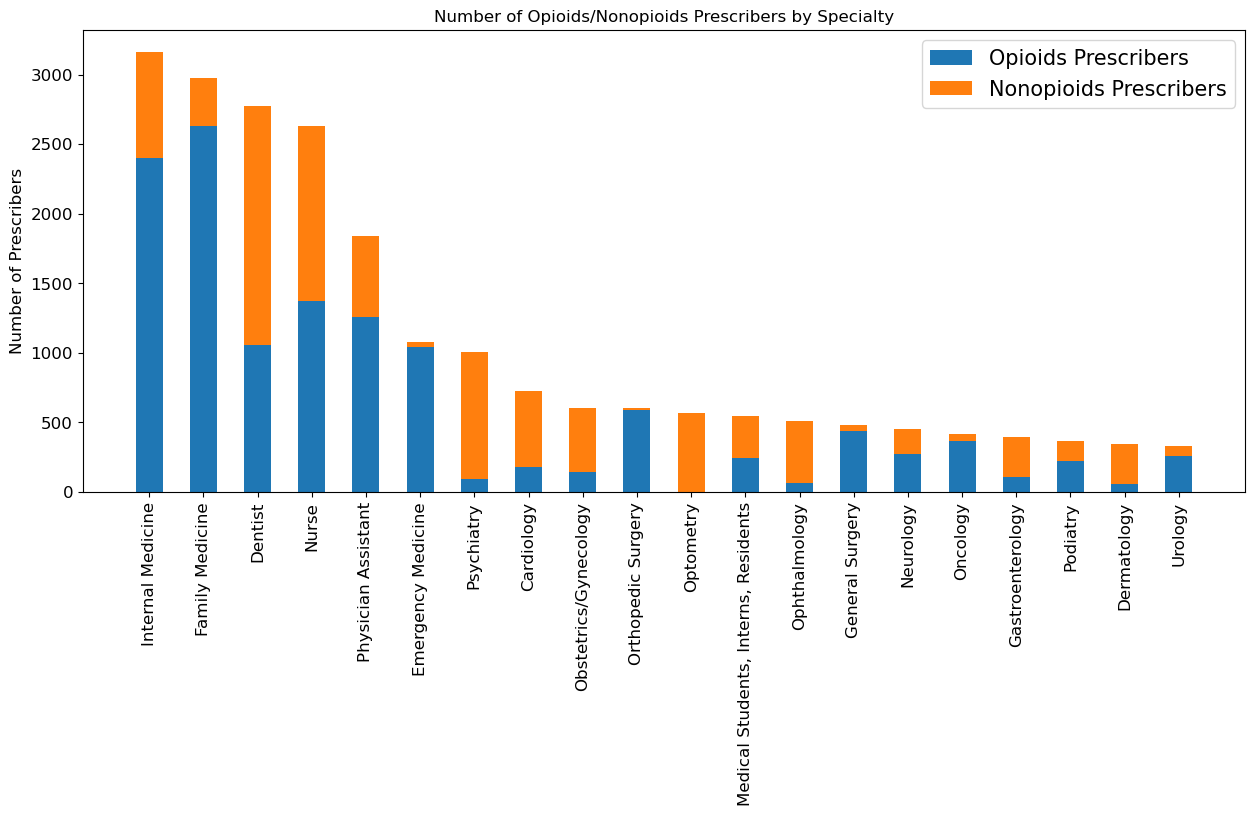

In [25]:
chart_df =  df_specialty.sort_values(by=['Total Drug Prescribers'], ascending=False)
x = list(chart_df['Specialty'][:20])
y_opi_prescriber = list(chart_df['Total Opioid Prescribers'][:20])
y_nonopi_prescriber = list(chart_df['Total Nonopioid Prescribers'][:20])
width = 0.5       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()
fig.set_size_inches( 15, 6)
ax.bar(x, y_opi_prescriber, width,label='Opioids Prescribers')
ax.bar(x, y_nonopi_prescriber, width, bottom=y_opi_prescriber, label='Nonopioids Prescribers')

ax.set_ylabel('Number of Prescribers')
ax.set_title('Number of Opioids/Nonopioids Prescribers by Specialty')
ax.legend()
plt.legend(fontsize=15)
plt.xticks(rotation = 90, fontsize = 12)
plt.ylabel("Number of Prescribers", fontsize=12)
plt.yticks(fontsize=12)
plt.show()


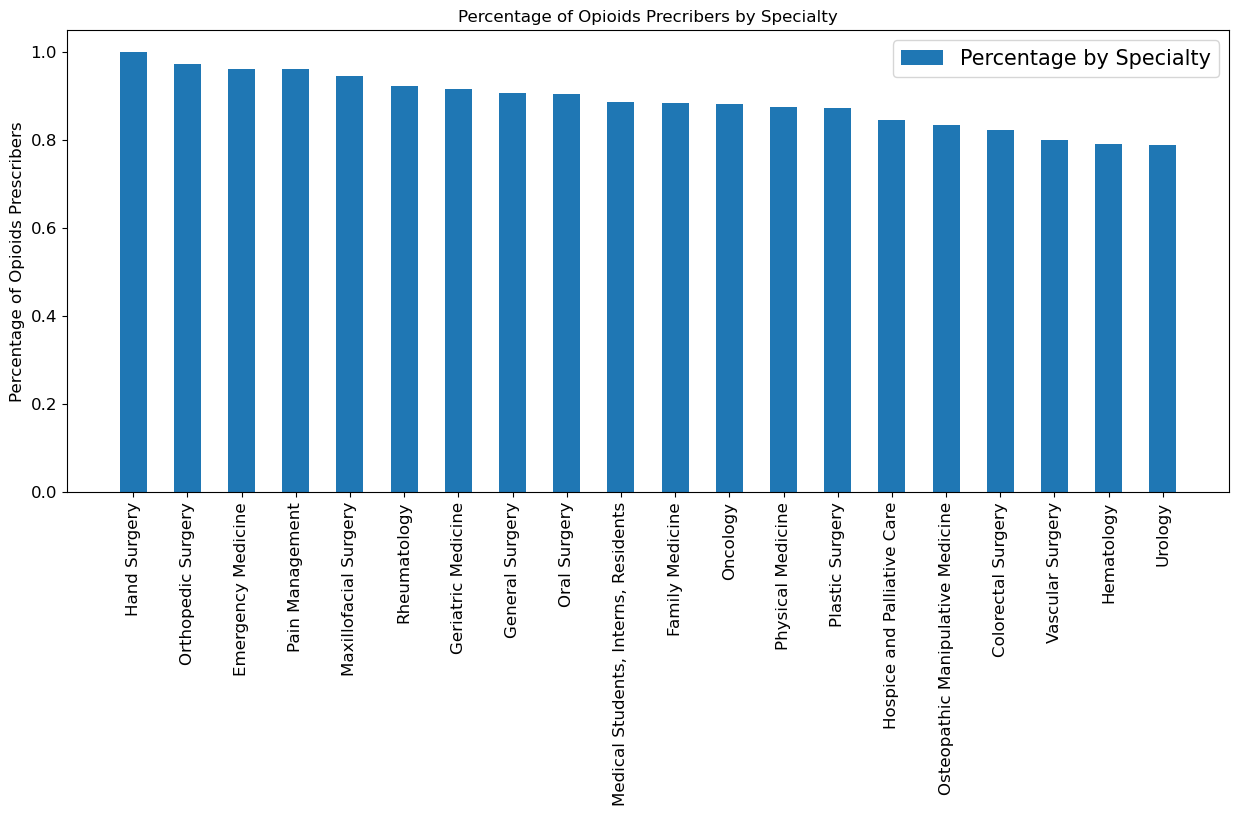

In [26]:


x = list(df_specialty_percentage['Specialty'][:20])
#y_opi_prescriber = list(df_state['Total Opioid Prescribers'][:20])
#y_nonopi_prescriber = list(df_state['Total Nonopioid Prescribers'][:20])
y_opi_percentage = list(df_specialty_percentage['Percentage of Opioids Prescribers'][:20])
width = 0.5       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()
fig.set_size_inches( 15, 6)
ax.bar(x, y_opi_percentage, width,label='Percentage by Specialty')
#ax.bar(x, y_nonopi_prescriber, width, bottom=y_opi_prescriber, label='Nonopioids Prescribers')


ax.set_title('Percentage of Opioids Precribers by Specialty', fontsize = 12)
ax.legend()
plt.legend(fontsize=15)
plt.xticks(rotation = 90, fontsize = 12)
plt.ylabel("Percentage of Opioids Prescribers", fontsize=12)
plt.yticks(fontsize=12)
plt.show()


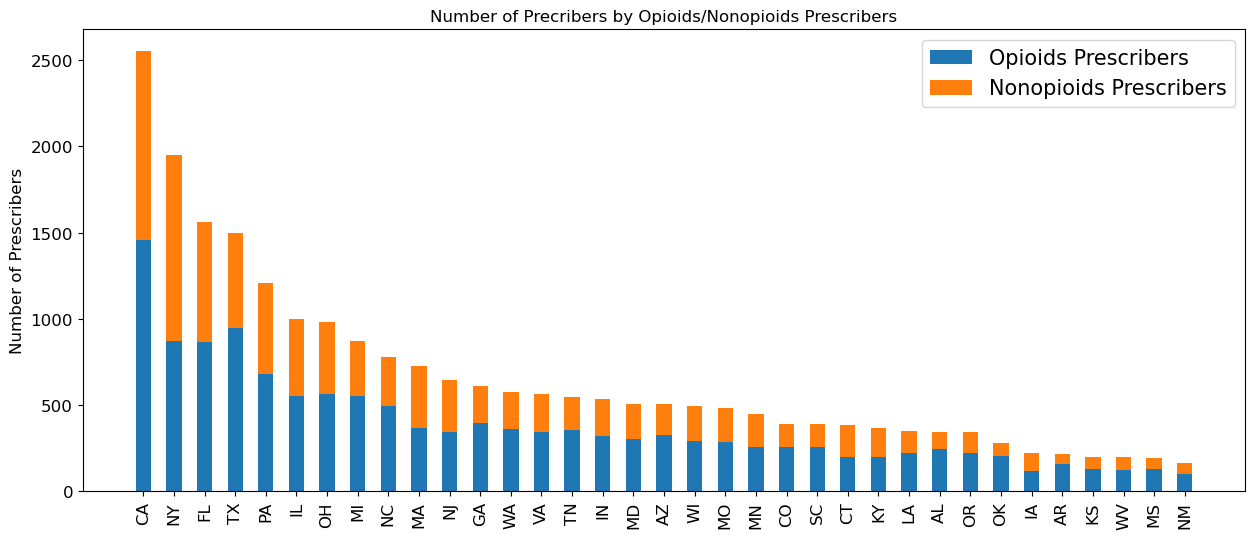

In [27]:
chart_df =  df_state.sort_values(by=['Total Drug Prescribers'], ascending=False)
x = list(chart_df['State'][:35])
y_opi_prescriber = list(chart_df['Total Opioid Prescribers'][:35])
y_nonopi_prescriber = list(chart_df['Total Nonopioid Prescribers'][:35])
y_opi_percentage = list(chart_df['Percentage of Opioids Prescribers'][:35])
width = 0.5       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()
fig.set_size_inches( 15, 6)
ax.bar(x, y_opi_prescriber, width,label='Opioids Prescribers')
ax.bar(x, y_nonopi_prescriber, width, bottom=y_opi_prescriber, label='Nonopioids Prescribers')

#ax.set_ylabel('Number of Prescribers')
ax.set_title('Number of Precribers by Opioids/Nonopioids Prescribers', fontsize = 12)
ax.legend()
plt.legend(fontsize=15)
plt.xticks(rotation = 90, fontsize = 12)
plt.ylabel("Number of Prescribers", fontsize=12)
plt.yticks(fontsize=12)
plt.show()


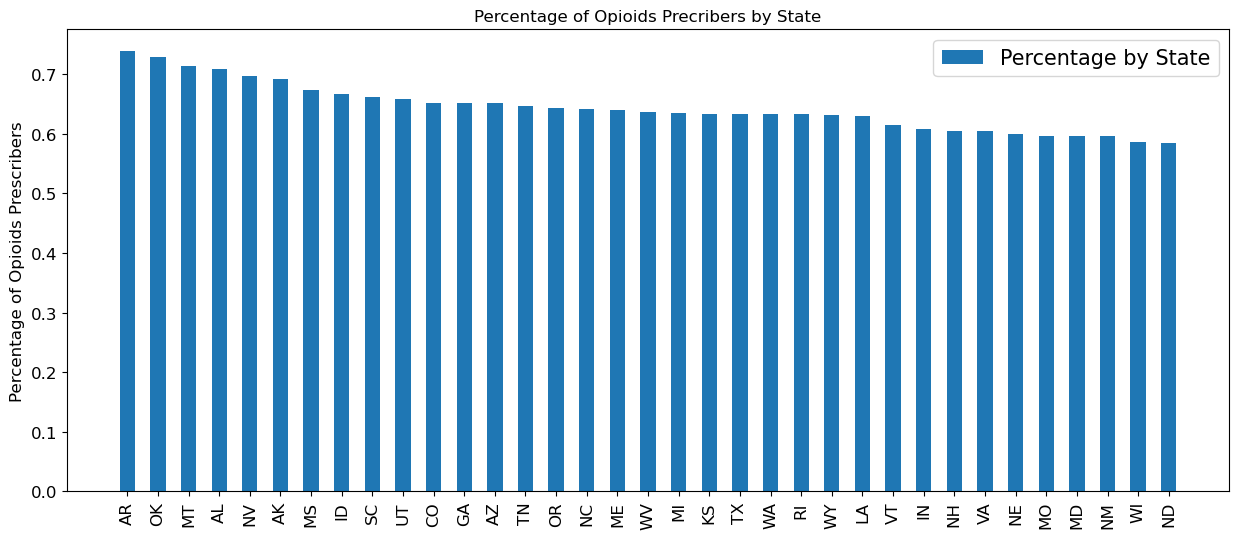

In [28]:
chart_df =  df_state.sort_values(by=['Percentage of Opioids Prescribers'], ascending=False)
x = list(chart_df['State'][:35])
#y_opi_prescriber = list(df_state['Total Opioid Prescribers'][:20])
#y_nonopi_prescriber = list(df_state['Total Nonopioid Prescribers'][:20])
y_opi_percentage = list(chart_df['Percentage of Opioids Prescribers'][:35])
width = 0.5       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()
fig.set_size_inches( 15, 6)
ax.bar(x, y_opi_percentage, width,label='Percentage by State')
#ax.bar(x, y_nonopi_prescriber, width, bottom=y_opi_prescriber, label='Nonopioids Prescribers')


ax.set_title('Percentage of Opioids Precribers by State', fontsize = 12)
ax.legend()
plt.legend(fontsize=15)
plt.xticks(rotation = 90, fontsize = 12)
plt.ylabel("Percentage of Opioids Prescribers", fontsize=12)
plt.yticks(fontsize=12)
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


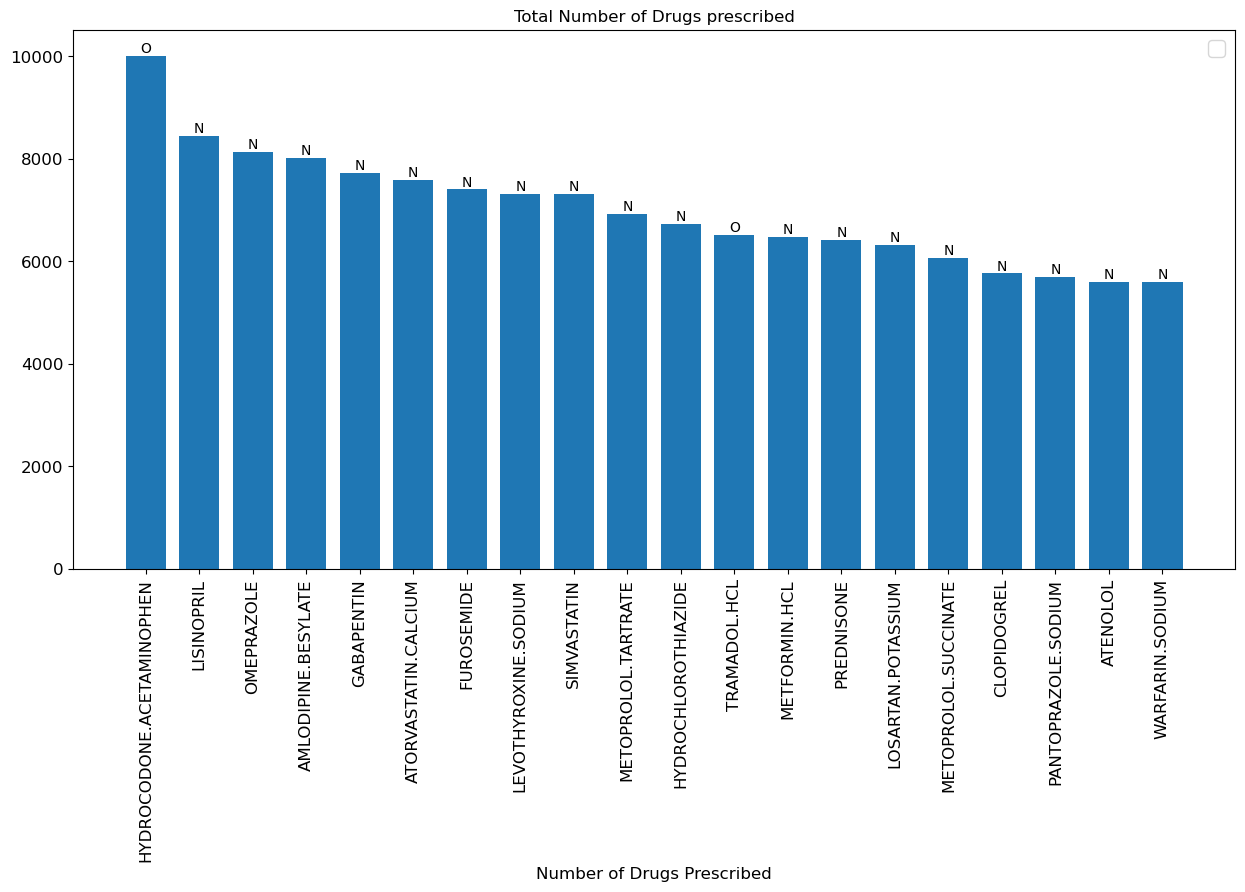

In [29]:
#DRUG SUMMARY 

opioid_list = list(set(opioids['Drug Name']) & set(df.columns.tolist()))

drug_summary_opioids = drug_summary[drug_summary['index'].isin(opioid_list)].copy()
drug_summary_nonopioids = drug_summary[~drug_summary['index'].isin(opioid_list)].copy()
drug_summary_opioids['label'] = 'O'
drug_summary_nonopioids['label'] = 'N'
drug_summary_plot = pd.concat([drug_summary_opioids,drug_summary_nonopioids])
drug_summary_plot =  drug_summary_plot.sort_values(by=['count'], ascending=False)


x = list(drug_summary_plot.iloc[:,0][:20])
y_drugs = list(drug_summary_plot.iloc[:,1][:20])
width = 0.75       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()
fig.set_size_inches( 15, 7)
ax.bar(x, y_drugs, width)
#ax.bar(x, y_nonopi_prescriber, width, bottom=y_opi_prescriber, label='Nonopioids Prescribers')


ax.set_title('Total Number of Drugs prescribed', fontsize = 12)
#ax.legend()
plt.legend(fontsize=15)
plt.xticks(rotation = 90, fontsize = 12)
plt.xlabel("Number of Drugs Prescribed", fontsize=12)
plt.yticks(fontsize=12)

rects = ax.patches

# Make some labels.
labels = list(drug_summary_plot['label'])

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
    )

plt.show()


In [30]:
overdoses = pd.read_csv('overdoses.csv')
overdoses = overdoses[['State', 'Abbrev', 'Population', 'Deaths']]

#add DC
dc = {'State': ['District of Columbia'],
      'Abbrev': ['DC'],
      'Population': ['658,893'],
      'Deaths': ['96']}
dc = pd.DataFrame(dc).astype('object')

overdoses = pd.concat([overdoses,dc], ignore_index = True)
overdoses["Population"] = overdoses["Population"].apply(lambda x: int(re.sub(',','', x)))
overdoses["Deaths"] = overdoses["Deaths"].apply(lambda x: int(re.sub(',','', x)))
overdoses["Deaths Per 100K"] = round(overdoses["Deaths"]/overdoses["Population"]*100000,2)

In [31]:
#import website
f = requests.get('https://www.cdc.gov/drugoverdose/rxrate-maps/state2014.html')
soup = BeautifulSoup(f.text)

In [32]:

#import column headers
Ourlist = soup.find("thead",{"class":"thead-dark"})
inner_col = [item.text for item in Ourlist.find_all('th')]
#import dataframe rows as list
Ourlist = soup.find("tbody")
inner_text = [item.text for item in Ourlist.find_all('td')]

#slice list after every 3rd element
lst = [inner_text[x:x+3] for x in range(0, len(inner_text), 3)]
#put dataframe together
dispensing_df = pd.DataFrame(lst, columns =inner_col)
dispensing_df['Opioid Dispensing Rate per 100']=dispensing_df['Opioid Dispensing Rate per 100'].astype('float64')

#DC is not a state
#dispensing_df = dispensing_df[~dispensing_df.State.str.contains('District of Columbia')]

#reset index after deleting DC
#dispensing_df.reset_index(drop = True)

#Opioid Dispensing Rate per 100 == Opioid Dispensing Rate Per 100 Persons
new_overdoses_df = pd.merge(overdoses, dispensing_df,  how='right', left_on=['State'], right_on = ['State'])

del new_overdoses_df['State Abbreviation']
#new_overdoses_df =  new_overdoses_df.sort_values(by=['Opioid Dispensing Rate per 100'], ascending=False)
new_overdoses_df =  new_overdoses_df.sort_values(by=['Deaths Per 100K'], ascending=False)
new_overdoses_df.head(15)

,State,Abbrev,Population,Deaths,Deaths Per 100K,Opioid Dispensing Rate per 100
48,West Virginia,WV,1854304,627,33.81,126.4
31,New Mexico,NM,2085287,547,26.23,71.5
29,New Hampshire,NH,1323459,334,25.24,79.6
17,Kentucky,KY,4395295,1077,24.50,110.0
35,Ohio,OH,11570808,2744,23.71,89.5
39,Rhode Island,RI,1051511,247,23.49,72.8
38,Pennsylvania,PA,12773801,2732,21.39,79.9
44,Utah,UT,2900872,603,20.79,78.8
7,Delaware,DE,925749,189,20.42,91.0
36,Oklahoma,OK,3850568,777,20.18,110.9


In [33]:
# choropleth map of deaths
fig = px.choropleth(new_overdoses_df, locations="Abbrev", locationmode="USA-states", 
                    scope="usa", color="Deaths Per 100K", color_continuous_scale="Viridis_r")
fig.update_layout(title_text = 'Deaths due to Opioid Overdose (Per 100K)', title_font_size = 22,
                  title_font_color="black", title_x=0.5)
#fig.update_layout(coloraxis_colorbar_x=0.7)
fig.layout.coloraxis.colorbar.title = ''
plot(fig)

'temp-plot.html'

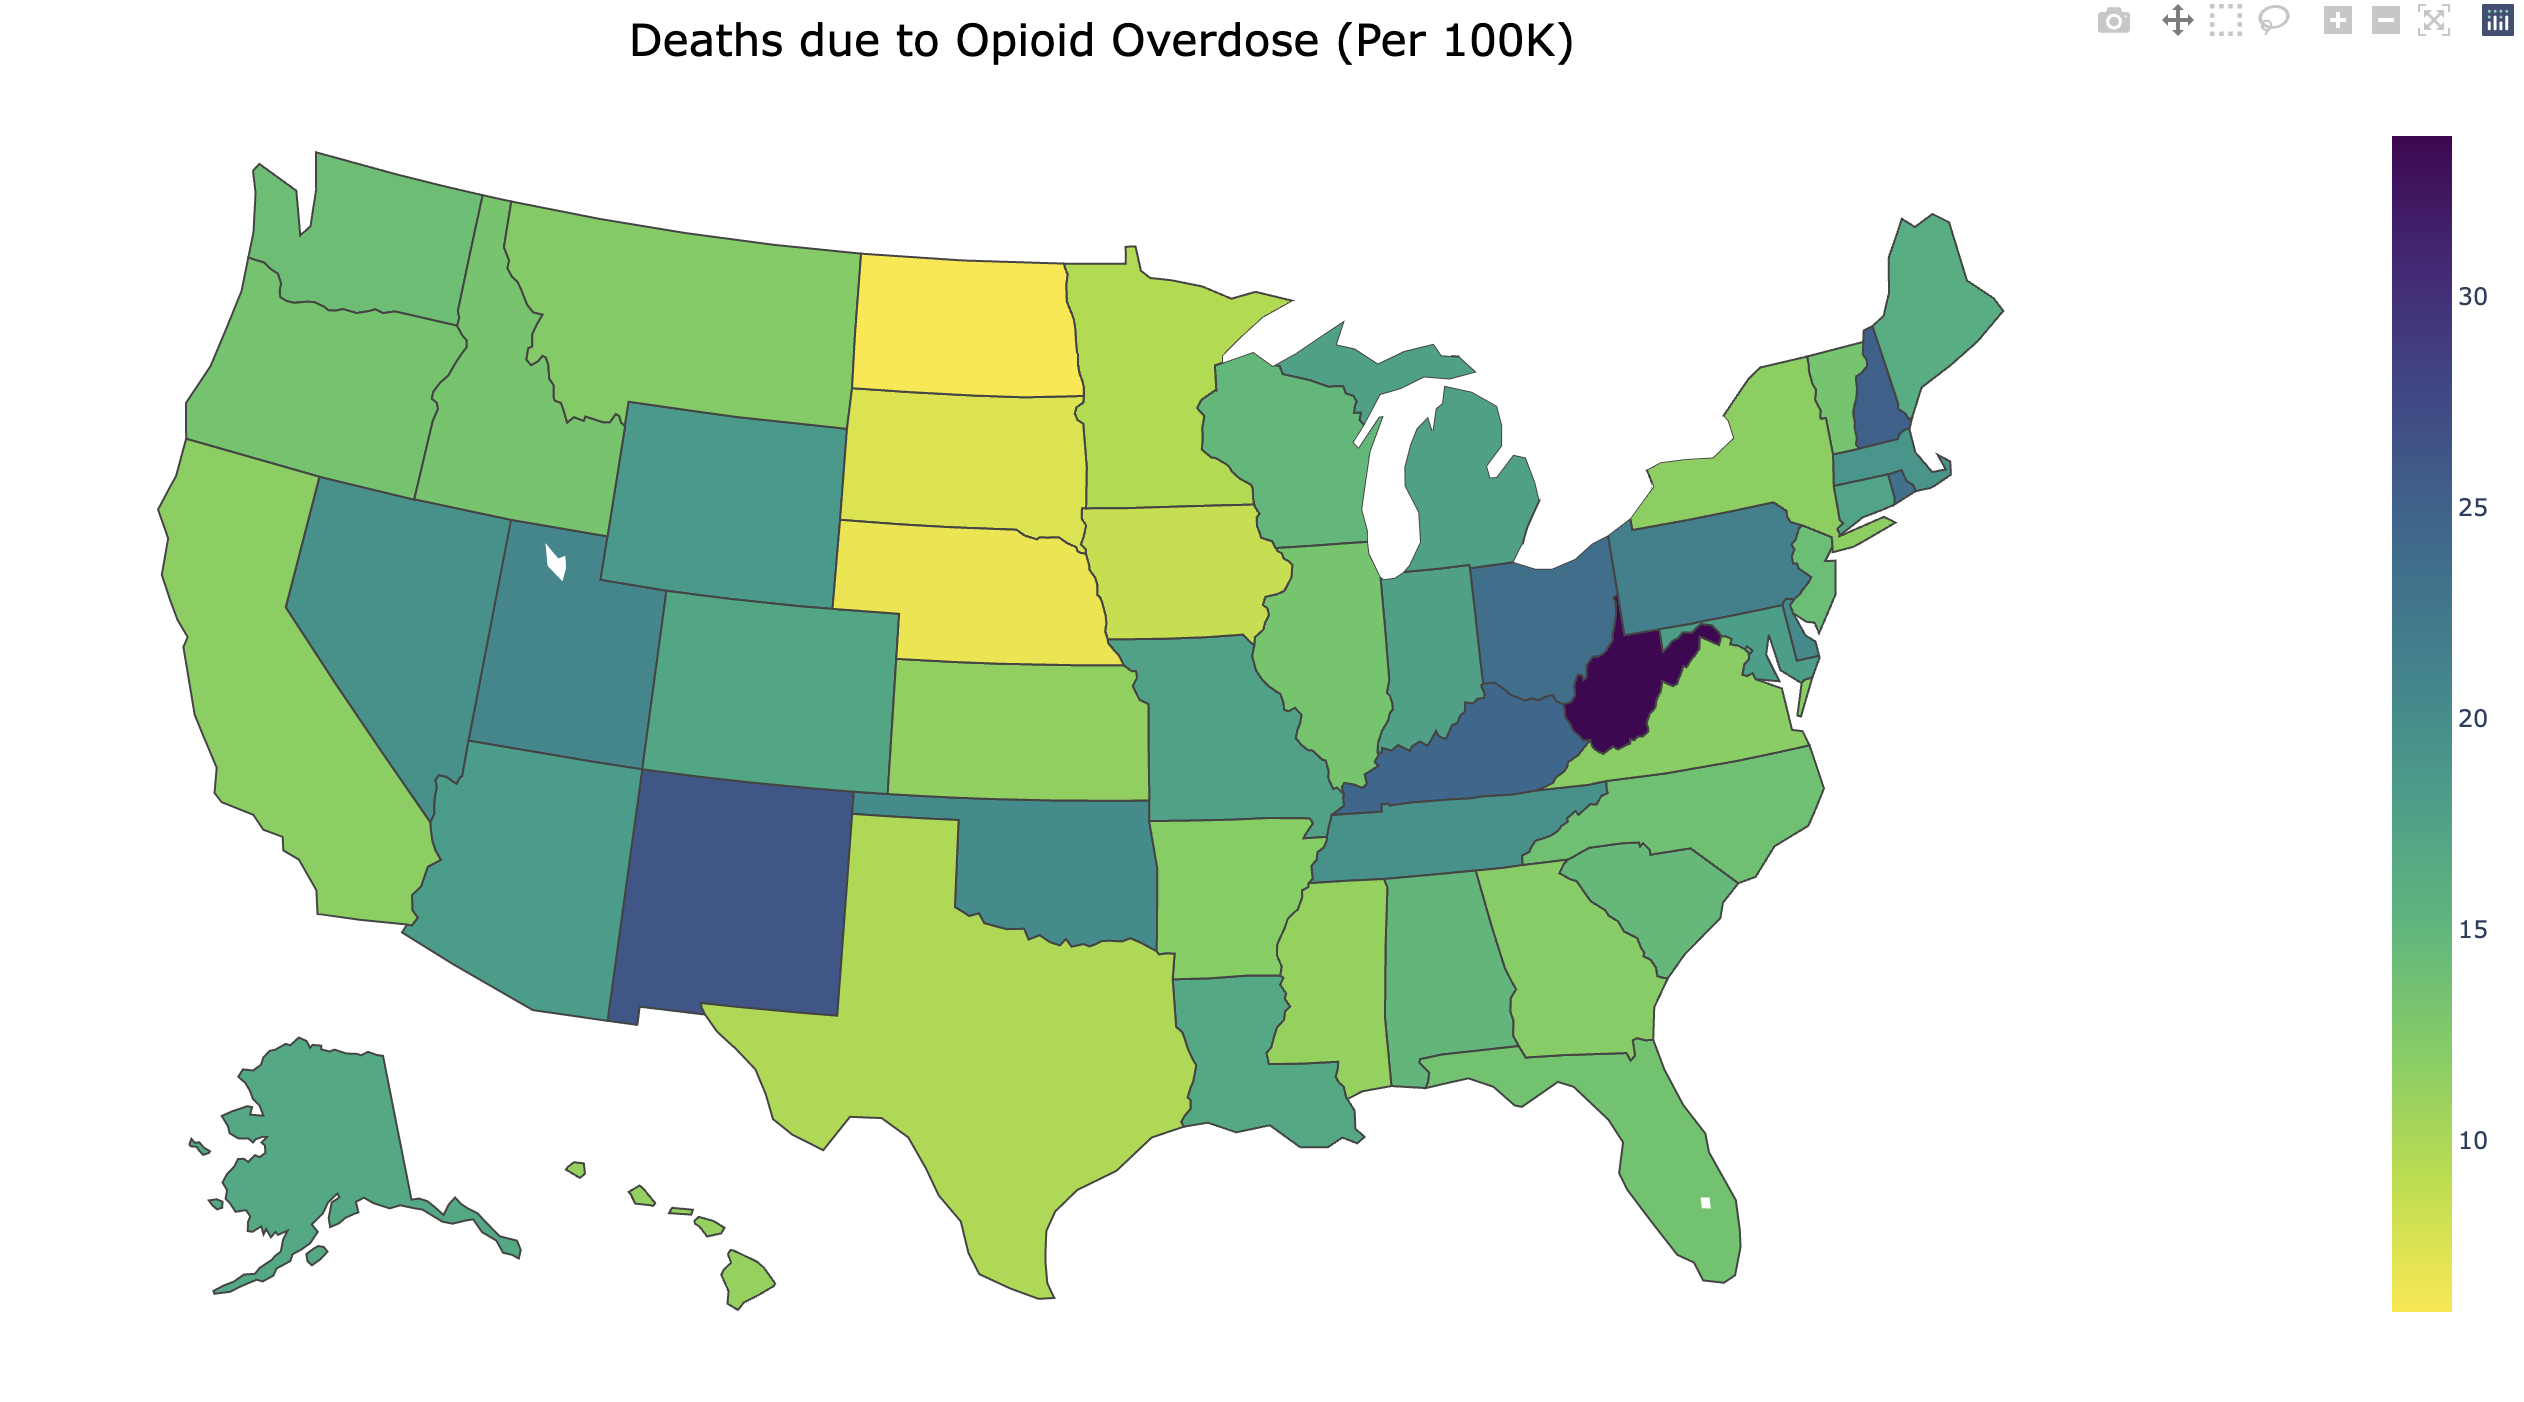

In [34]:
# choropleth map of opioid dispensing rate
fig = px.choropleth(new_overdoses_df, locations="Abbrev", locationmode="USA-states", 
                    scope="usa", color="Opioid Dispensing Rate per 100", color_continuous_scale="Viridis_r")
fig.update_layout(title_text = 'Opioid Dispensing Rate (Per 100 Persons)', title_font_size = 22,
                  title_font_color="black", title_x=0.5)
# fig.update_layout(coloraxis_colorbar_x=0.7)
fig.layout.coloraxis.colorbar.title = ''
plot(fig)

'temp-plot.html'

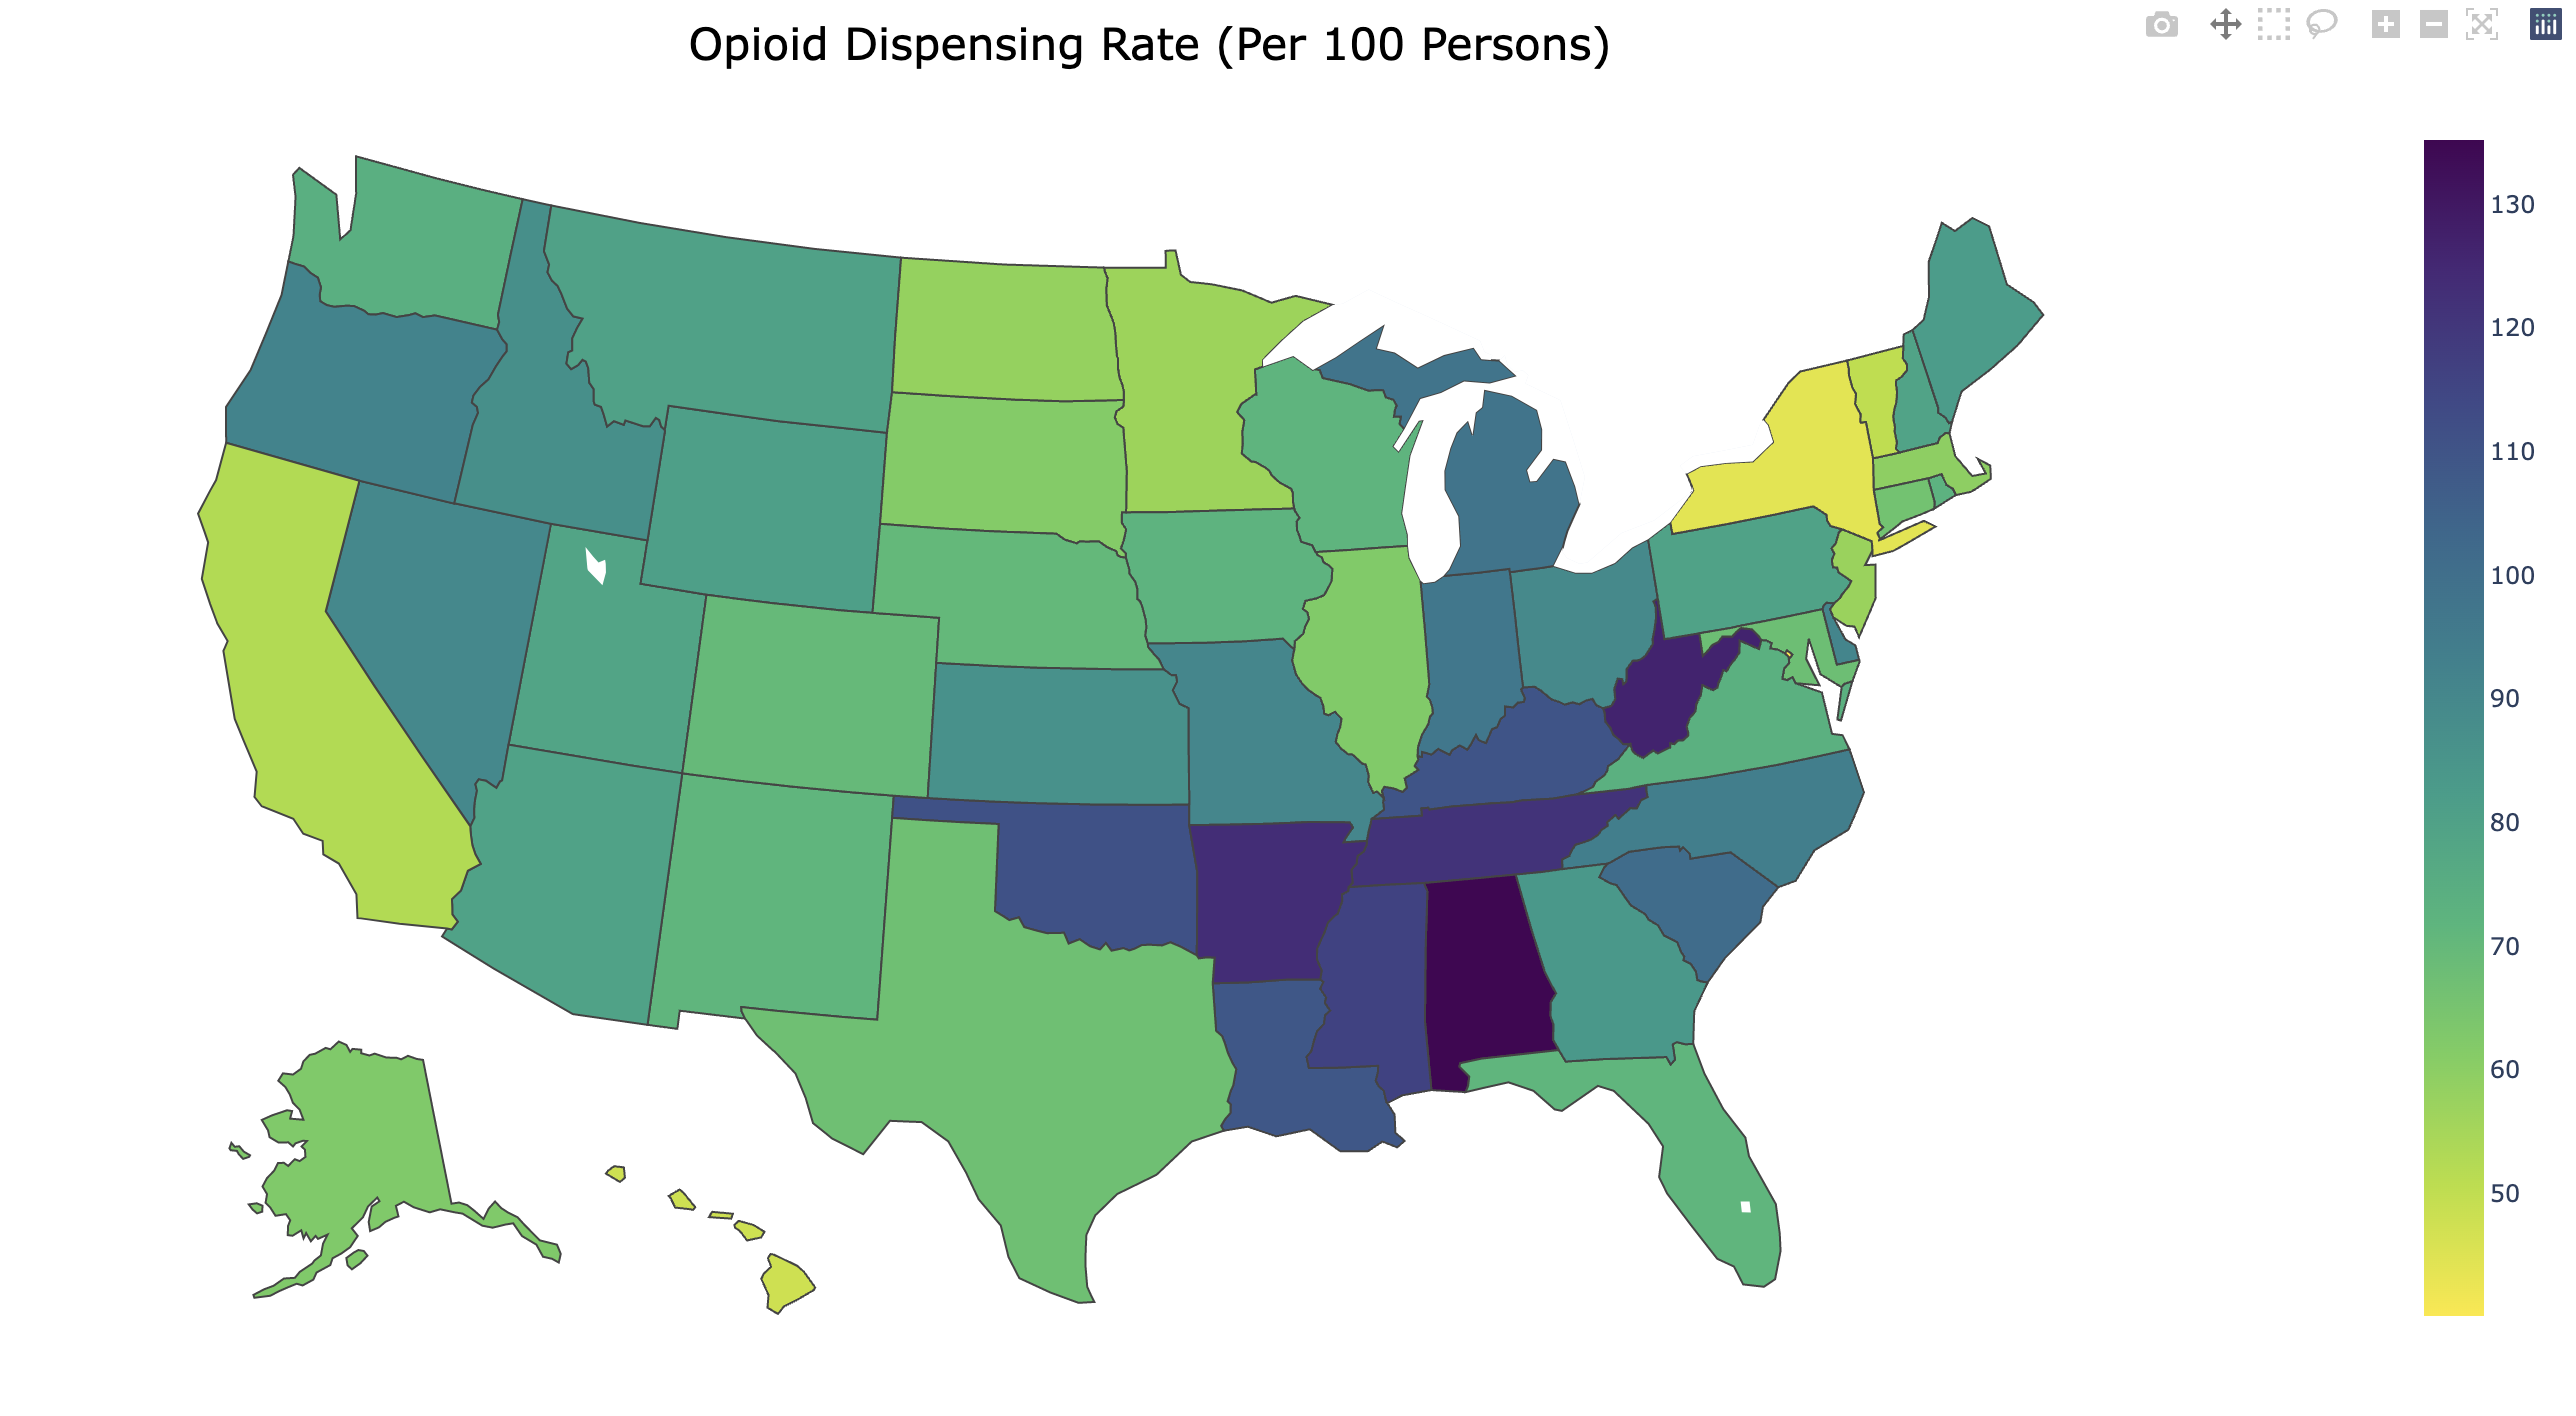